In [89]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.datasets import make_classification

from sklearn import cross_validation
from sklearn.metrics import accuracy_score,f1_score
import math

In [90]:
import warnings; warnings.simplefilter('ignore')

## Applying randomized optimization algorithms to a Multi-layer perceptron

### Cosntruct the MLP class with 1 hidden layer which has following parameters and methods
* Hidden layer size i.e. number of neurons
* Choice of the optimization method for gradient based methods
* Parameter for random weight initialization
* **`Fit()`** method for gradient (Jacobian) and 2nd-derivative (Hessian) based optimization techniques
* **`Fit_simplex()`** method for optimization through simple downhill descent (***derivative-free***)
* **`Fit_anneal()`** method for optimization through simulated annealing (***derivative-free***)
* **`Fit_de()`** method for optimization through differential evolution (from **genetic algorithm** class) (***derivative-free***) 

In [91]:
class NN_1HL(object):

    def __init__(self, reg_lambda=0, epsilon_init=0.12, hidden_layer_size=25, opti_method='TNC', maxiter=500):
        self.reg_lambda = reg_lambda
        self.epsilon_init = epsilon_init
        self.hidden_layer_size = hidden_layer_size
        self.activation_func = self.sigmoid
        self.activation_func_prime = self.sigmoid_prime
        self.method = opti_method
        self.maxiter = maxiter

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_prime(self, z):
        sig = self.sigmoid(z)
        return sig * (1 - sig)

    def sumsqr(self, a):
        return np.sum(a ** 2)

    def rand_init(self, l_in, l_out):
        self.epsilon_init = (math.sqrt(6))/(math.sqrt(l_in + l_out))
        return np.random.rand(l_out, l_in + 1) * 2 * self.epsilon_init - self.epsilon_init

    def pack_thetas(self, t1, t2):
        return np.concatenate((t1.reshape(-1), t2.reshape(-1)))

    def unpack_thetas(self, thetas, input_layer_size, hidden_layer_size, num_labels):
        t1_start = 0
        t1_end = hidden_layer_size * (input_layer_size + 1)
        t1 = thetas[t1_start:t1_end].reshape((hidden_layer_size, input_layer_size + 1))
        t2 = thetas[t1_end:].reshape((num_labels, hidden_layer_size + 1))
        return t1, t2

    def _forward(self, X, t1, t2):
        m = X.shape[0]
        ones = None
        if len(X.shape) == 1:
            ones = np.array(1).reshape(1,)
        else:
            ones = np.ones(m).reshape(m,1)

        # Input layer
        a1 = np.hstack((ones, X))

        # Hidden Layer
        z2 = np.dot(t1, a1.T)
        a2 = self.activation_func(z2)
        a2 = np.hstack((ones, a2.T))

        # Output layer
        z3 = np.dot(t2, a2.T)
        a3 = self.activation_func(z3)
        return a1, z2, a2, z3, a3

    def function(self, thetas, input_layer_size, hidden_layer_size, num_labels, X, y, reg_lambda):
        t1, t2 = self.unpack_thetas(thetas, input_layer_size, hidden_layer_size, num_labels)

        m = X.shape[0]
        Y = np.eye(num_labels)[y]

        _, _, _, _, h = self._forward(X, t1, t2)
        costPositive = -Y * np.log(h).T
        costNegative = (1 - Y) * np.log(1 - h).T
        cost = costPositive - costNegative
        J = np.sum(cost) / m

        if reg_lambda != 0:
            t1f = t1[:, 1:]
            t2f = t2[:, 1:]
            reg = (self.reg_lambda / (2 * m)) * (self.sumsqr(t1f) + self.sumsqr(t2f))
            J = J + reg
        return J

    def function_prime(self, thetas, input_layer_size, hidden_layer_size, num_labels, X, y, reg_lambda):
        t1, t2 = self.unpack_thetas(thetas, input_layer_size, hidden_layer_size, num_labels)

        m = X.shape[0]
        t1f = t1[:, 1:]
        t2f = t2[:, 1:]
        Y = np.eye(num_labels)[y]

        Delta1, Delta2 = 0, 0
        for i, row in enumerate(X):
            a1, z2, a2, z3, a3 = self._forward(row, t1, t2)

            # Backprop
            d3 = a3 - Y[i, :].T
            d2 = np.dot(t2f.T, d3) * self.activation_func_prime(z2)

            Delta2 += np.dot(d3[np.newaxis].T, a2[np.newaxis])
            Delta1 += np.dot(d2[np.newaxis].T, a1[np.newaxis])

        Theta1_grad = (1 / m) * Delta1
        Theta2_grad = (1 / m) * Delta2

        if reg_lambda != 0:
            Theta1_grad[:, 1:] = Theta1_grad[:, 1:] + (reg_lambda / m) * t1f
            Theta2_grad[:, 1:] = Theta2_grad[:, 1:] + (reg_lambda / m) * t2f

        return self.pack_thetas(Theta1_grad, Theta2_grad)

    def fit(self, X, y):
        num_features = X.shape[0]
        input_layer_size = X.shape[1]
        num_labels = len(set(y))

        theta1_0 = self.rand_init(input_layer_size, self.hidden_layer_size)
        theta2_0 = self.rand_init(self.hidden_layer_size, num_labels)
        thetas0 = self.pack_thetas(theta1_0, theta2_0)

        options = {'maxiter': self.maxiter}
        _res = optimize.minimize(self.function, thetas0, jac=self.function_prime, method=self.method, 
                                 args=(input_layer_size, self.hidden_layer_size, num_labels, X, y, 0), 
                                 options=options)
        
        #print(_res)

        self.t1, self.t2 = self.unpack_thetas(_res.x, input_layer_size, self.hidden_layer_size, num_labels)

        np.savetxt("weights_t1.txt", self.t1, newline="\n")
        np.savetxt("weights_t2.txt", self.t2, newline="\n")
        
    def fit_simplex(self, X, y,status=False):
        num_features = X.shape[0]
        input_layer_size = X.shape[1]
        num_labels = len(set(y))

        theta1_0 = self.rand_init(input_layer_size, self.hidden_layer_size)
        theta2_0 = self.rand_init(self.hidden_layer_size, num_labels)
        thetas0 = self.pack_thetas(theta1_0, theta2_0)

        options = {'maxiter': self.maxiter}
        _res = optimize.fmin(self.function, thetas0, maxiter=self.maxiter,disp=status,
                            args=(input_layer_size, self.hidden_layer_size, num_labels, X, y, 0))
        
        _res=np.array(_res)
        if status:
            print(_res)

        self.t1, self.t2 = self.unpack_thetas(_res, input_layer_size, self.hidden_layer_size, num_labels)

        np.savetxt("weights_t1.txt", self.t1, newline="\n")
        np.savetxt("weights_t2.txt", self.t2, newline="\n")
        
    def fit_anneal(self, X, y,temp=None,status=False):
        num_features = X.shape[0]
        input_layer_size = X.shape[1]
        num_labels = len(set(y))

        theta1_0 = self.rand_init(input_layer_size, self.hidden_layer_size)
        theta2_0 = self.rand_init(self.hidden_layer_size, num_labels)
        thetas0 = self.pack_thetas(theta1_0, theta2_0)

        options = {'maxiter': self.maxiter}
        
        if temp!=None:
            model_T=temp
        
        _res = optimize.basinhopping(self.function, thetas0, niter=self.maxiter,T=model_T,disp=status,
                                    minimizer_kwargs={'args':(input_layer_size, self.hidden_layer_size, 
                                                              num_labels, X, y, 0)})
        
        if status:
            print(_res)

        self.t1, self.t2 = self.unpack_thetas(_res.x, input_layer_size, self.hidden_layer_size, num_labels)

        np.savetxt("weights_t1.txt", self.t1, newline="\n")
        np.savetxt("weights_t2.txt", self.t2, newline="\n")
        
    def fit_de(self, X, y,bound=10,status=False,strategy='best1bin',popsize=10,mutation=(0.5,1.0),
              recombination=0.7,init='latinhypercube'):
        """
        Fits a differential evolution algorithm
        bound: Bounds for variables
        """
        num_features = X.shape[0]
        input_layer_size = X.shape[1]
        num_labels = len(set(y))

        theta1_0 = self.rand_init(input_layer_size, self.hidden_layer_size)
        theta2_0 = self.rand_init(self.hidden_layer_size, num_labels)
        thetas0 = self.pack_thetas(theta1_0, theta2_0)

        options = {'maxiter': self.maxiter}
        
        _res = optimize.differential_evolution(self.function, bounds=[(-bound,bound)]*len(thetas0), 
                                               maxiter=self.maxiter, disp=status,
                                    args=(input_layer_size, self.hidden_layer_size,num_labels, X, y, 0))
        
        if status:
            print(_res)

        self.t1, self.t2 = self.unpack_thetas(_res.x, input_layer_size, self.hidden_layer_size, num_labels)

        np.savetxt("weights_t1.txt", self.t1, newline="\n")
        np.savetxt("weights_t2.txt", self.t2, newline="\n")

    def predict(self, X):
        return self.predict_proba(X).argmax(0)

    def predict_proba(self, X):
        _, _, _, _, h = self._forward(X, self.t1, self.t2)
        return h

### For test - create some synthetic data

In [132]:
data = make_classification(n_samples=500,n_features=10,n_informative=8,
                           n_classes=2,n_redundant=2,class_sep=0.5,flip_y=0.1)

In [133]:
features=data[0]
response=data[1]
full_data=np.column_stack((features,response))

In [135]:
df=pd.DataFrame(full_data,columns=['X'+str(i) for i in range(10)]+['y'])

In [136]:
df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,y
0,-0.707228,-0.091718,1.366142,-1.638905,1.034314,0.457061,-1.125703,-1.403976,2.001021,1.262102,0.0
1,-0.247779,-1.254694,0.896102,0.053484,2.040638,0.969665,-0.085845,1.175116,2.393979,0.748807,0.0
2,-1.801084,1.371932,0.601973,0.110634,-2.366770,-0.918567,1.171675,-1.508922,-1.641504,-4.077089,0.0
3,0.277573,0.200249,-0.115067,0.330957,0.947562,1.615095,1.830136,0.062748,0.068971,-1.414749,0.0
4,0.614410,1.346785,-2.018468,0.905438,0.385929,-0.662869,0.605764,-0.602145,-2.268239,-0.193403,0.0


### Visualize

We plot histograms, boxlots and scatterplots of the dataset and observe that the **class separation is not very obvious**. Particularly, boxplots show lot of overlap between features for two output classes.

So, this should be a **non-trivial classification task.**

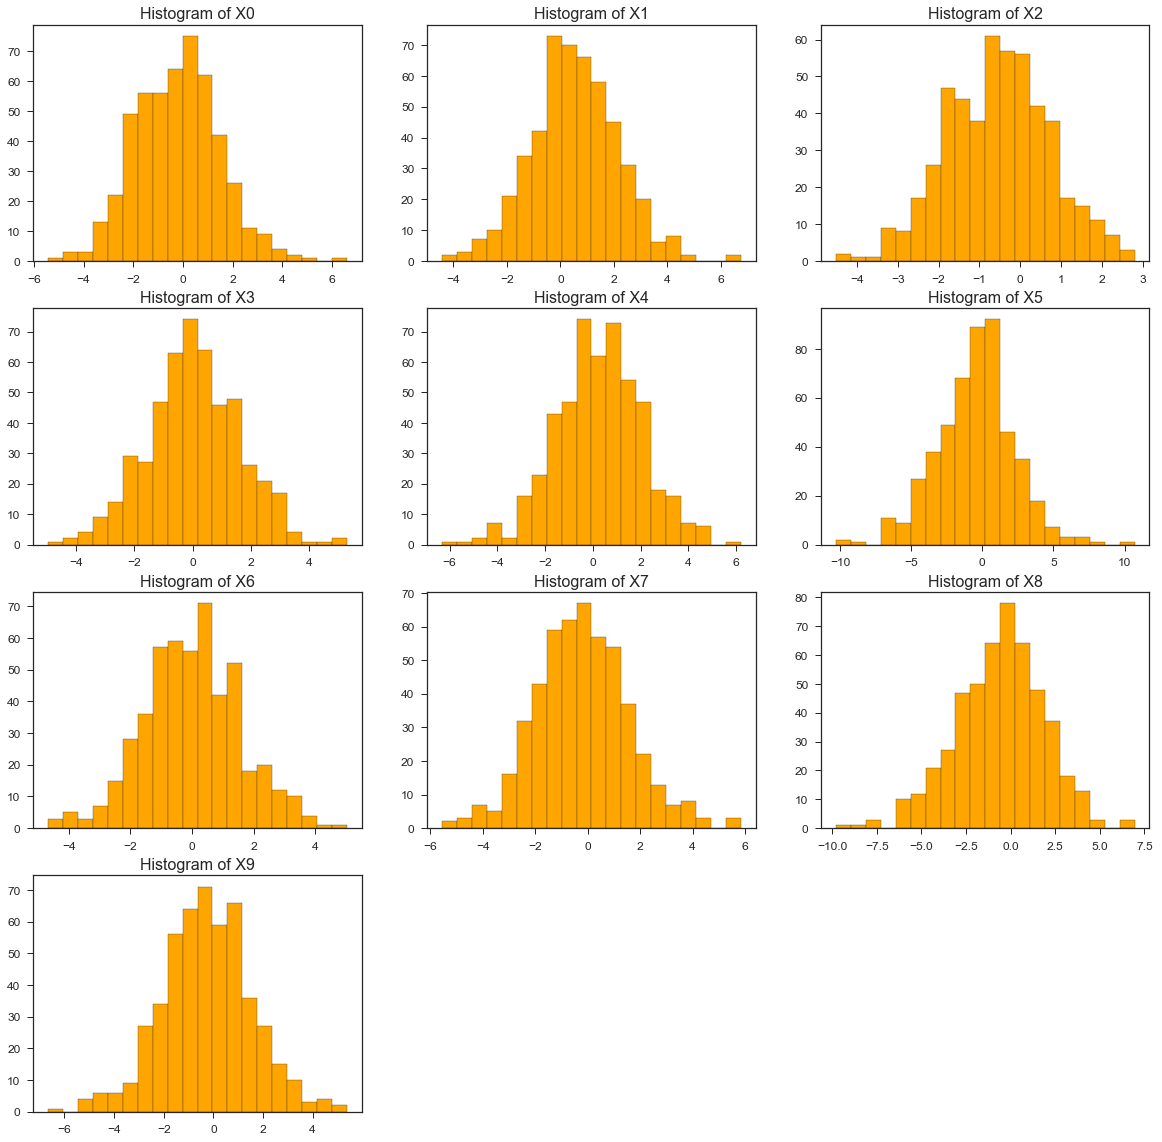

In [139]:
i=1
plt.figure(figsize=(20,20))
for c in df.describe().columns[:-1]:
    plt.subplot(4,3,i)
    plt.title(f"Histogram of {c}",fontsize=16)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.hist(df[c],bins=20,color='orange',edgecolor='k')
    i+=1
plt.show()

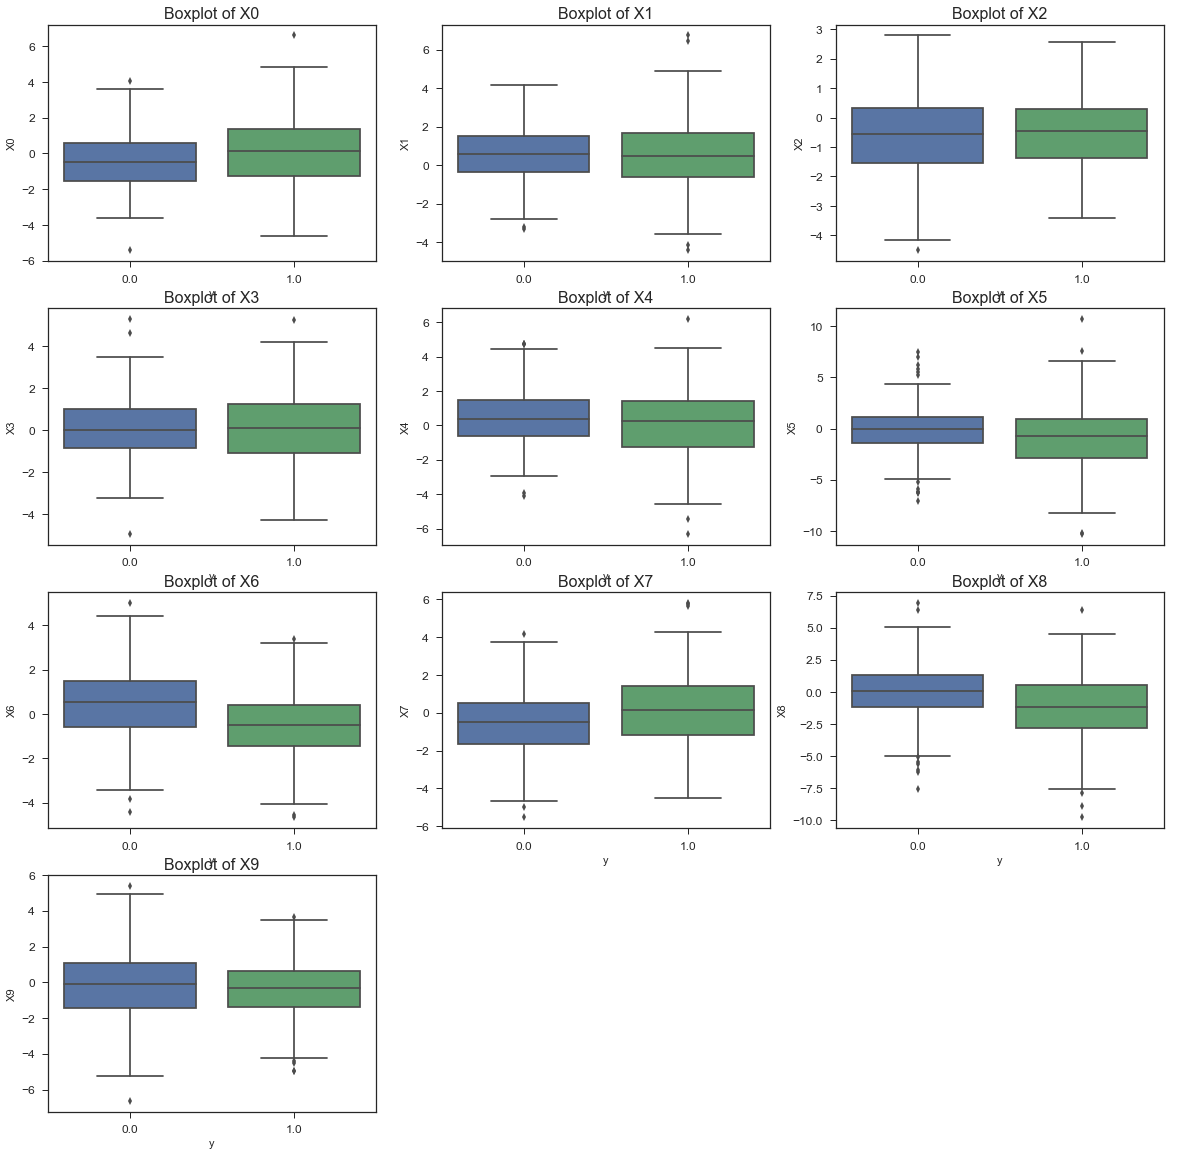

In [140]:
i=1
plt.figure(figsize=(20,20))
for c in df.columns[:-1]:
    plt.subplot(4,3,i)
    plt.title(f"Boxplot of {c}",fontsize=16)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    sns.boxplot(y=df[c],x=df['y'])
    i+=1
plt.show()

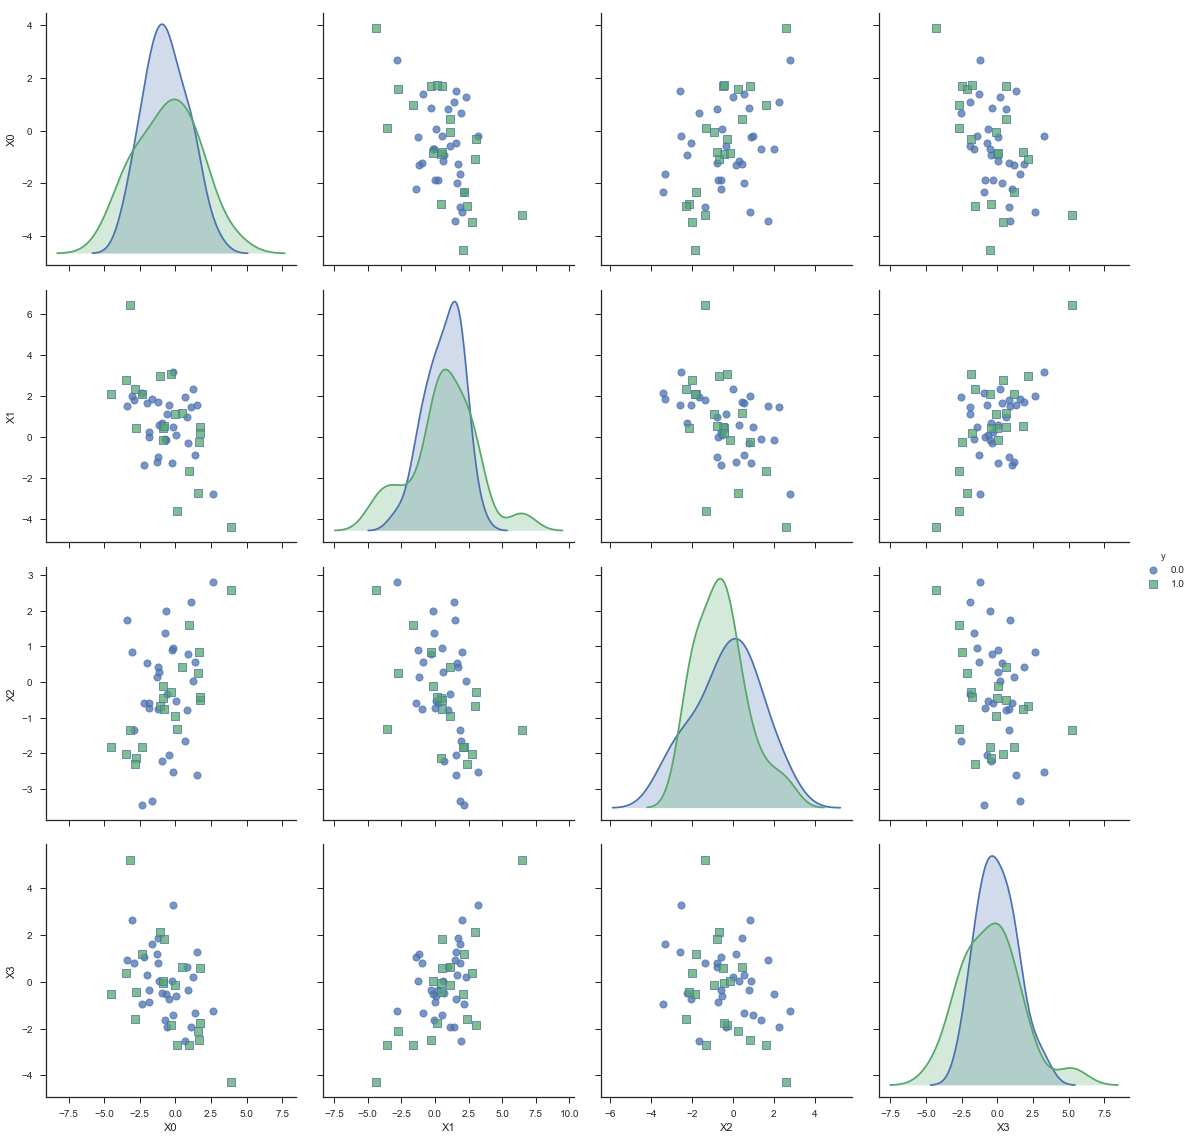

In [142]:
df_sample=df.sample(frac=0.1)
sns.set(style="ticks", color_codes=True)
g=sns.pairplot(df_sample,vars=['X0','X1','X2','X3'],
               plot_kws=dict(s=50, edgecolor="b", linewidth=1,alpha=0.75),
               hue="y",markers=["o", "s"], diag_kind="kde",diag_kws=dict(shade=True), size=4)

### Save the data in a text file

In [143]:
np.savetxt('scipy_test.txt',X=full_data,delimiter=', ')

### Read the data from the file

In [154]:
values = np.loadtxt('scipy_test.txt', delimiter=', ', usecols=[i for i in range(10)])
targets = np.loadtxt('scipy_test.txt', delimiter=', ', dtype=(int), usecols=[10])

### Standard scaling and min/max scaling

In [155]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [156]:
sc=StandardScaler()
mms = MinMaxScaler()

In [157]:
values_scaled=sc.fit_transform(values)
values_minmax=mms.fit_transform(values)

In [158]:
values_scaled[1:10]

array([[-0.02336662, -1.10305152,  1.1348675 , -0.00997047,  0.9909208 ,
         0.52509456, -0.07286128,  0.77479087,  1.20778891,  0.56295375],
       [-0.9453038 ,  0.50330277,  0.90160291,  0.02612856, -1.46478606,
        -0.17655351,  0.73210276, -0.74273675, -0.42281069, -2.11823341],
       [ 0.28844674, -0.2132586 ,  0.33294116,  0.16529938,  0.3818842 ,
         0.76492983,  1.15359708,  0.14586924,  0.26833341, -0.63908186],
       [ 0.48837049,  0.4879234 , -1.17658531,  0.52817804,  0.06895476,
        -0.0815388 ,  0.36985153, -0.23005422, -0.67605258,  0.03947765],
       [-0.22857613,  1.79138869, -1.08796922,  1.67664022, -0.77962128,
        -1.34225446,  0.18207819,  0.01691665, -2.29022485, -1.87271876],
       [ 2.12280787, -0.88907603,  1.16287099, -0.47344758, -0.94916322,
         1.13575114,  0.06637992,  1.23824613, -0.53770964, -0.34110077],
       [-0.66736462, -0.36503344, -0.26898407, -0.95961223, -1.65198088,
        -0.55191583, -0.67808853,  0.86693437

In [159]:
values_minmax[1:10]

array([[0.43004367, 0.28338976, 0.73990009, 0.48848441, 0.66772841,
        0.5360601 , 0.47215067, 0.59054608, 0.72769615, 0.61507424],
       [0.30080193, 0.51870854, 0.69961466, 0.49407939, 0.31511017,
        0.44602385, 0.60195866, 0.35453066, 0.48649412, 0.21362289],
       [0.47375522, 0.41373771, 0.60140524, 0.51564942, 0.58027603,
        0.56683602, 0.66992856, 0.49273224, 0.58872974, 0.43509471],
       [0.50178153, 0.51645557, 0.34070593, 0.57189183, 0.53534207,
        0.45821624, 0.54354225, 0.43426627, 0.449034  , 0.53669472],
       [0.40127638, 0.7074034 , 0.35601017, 0.74989153, 0.4134939 ,
        0.29643983, 0.51326204, 0.47267673, 0.21026194, 0.25038355],
       [0.73090509, 0.31473555, 0.74473636, 0.41665028, 0.38914914,
        0.61442022, 0.49460462, 0.66262555, 0.469498  , 0.47971111],
       [0.33976482, 0.39150384, 0.49745112, 0.34129982, 0.28823061,
        0.39785695, 0.37455211, 0.60487682, 0.54509793, 0.49606117],
       [0.26554562, 0.3967031 , 0.6324377

### Train/test split

In [160]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(values, targets, test_size=0.4)

In [161]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = cross_validation.train_test_split(values_scaled, targets, test_size=0.4)

In [162]:
X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax = cross_validation.train_test_split(values_minmax, targets, test_size=0.4)

### Fit with <span style=color:blue>simple hill climb (descent)</span> algorithm and show accuracy and F1 score

In [163]:
nn = NN_1HL(hidden_layer_size=5,maxiter=50000)
nn.fit_simplex(X_train, y_train)
print("Accuracy of classification: "+str(accuracy_score(y_test, nn.predict(X_test))))
print("F1 score of classification: "+str(f1_score(y_test, nn.predict(X_test))))

Accuracy of classification: 0.665
F1 score of classification: 0.5988023952095808


In [164]:
nn = NN_1HL(hidden_layer_size=5,maxiter=50000)
nn.fit_simplex(X_train_scaled, y_train_scaled)
print("Accuracy of classification: "+str(accuracy_score(y_test_scaled, nn.predict(X_test_scaled))))
print("F1 score of classification: "+str(f1_score(y_test_scaled, nn.predict(X_test_scaled))))

Accuracy of classification: 0.76
F1 score of classification: 0.7391304347826086


In [165]:
nn = NN_1HL(hidden_layer_size=5,maxiter=50000)
nn.fit_simplex(X_train_minmax, y_train_minmax)
print("Accuracy of classification: "+str(accuracy_score(y_test_minmax, nn.predict(X_test_minmax))))
print("F1 score of classification: "+str(f1_score(y_test_minmax, nn.predict(X_test_minmax))))

Accuracy of classification: 0.76
F1 score of classification: 0.7391304347826088


### Fit with <span style=color:blue>simulated annealing</span> algorithm and show accuracy and F1 score

In [169]:
nn = NN_1HL(hidden_layer_size=5,maxiter=20)
nn.fit_anneal(X_train, y_train,temp=10,status=True)
print("Accuracy of classification: "+str(accuracy_score(y_test, nn.predict(X_test))))
print("F1 score of classification: "+str(f1_score(y_test, nn.predict(X_test))))

basinhopping step 0: f 0.592075
basinhopping step 1: f 0.592074 trial_f 0.592074 accepted 1  lowest_f 0.592074
found new global minimum on step 1 with function value 0.592074
basinhopping step 2: f 0.592074 trial_f 0.592074 accepted 1  lowest_f 0.592074
found new global minimum on step 2 with function value 0.592074
basinhopping step 3: f 0.592074 trial_f 0.592074 accepted 1  lowest_f 0.592074
basinhopping step 4: f 0.592075 trial_f 0.592075 accepted 1  lowest_f 0.592074
basinhopping step 5: f 0.592074 trial_f 0.592074 accepted 1  lowest_f 0.592074
basinhopping step 6: f 0.592074 trial_f 0.592074 accepted 1  lowest_f 0.592074
found new global minimum on step 6 with function value 0.592074
basinhopping step 7: f 0.592074 trial_f 0.592074 accepted 1  lowest_f 0.592074
found new global minimum on step 7 with function value 0.592074
basinhopping step 8: f 0.592074 trial_f 0.592074 accepted 1  lowest_f 0.592074
basinhopping step 9: f 0.592074 trial_f 0.592074 accepted 1  lowest_f 0.592074
b

In [170]:
nn = NN_1HL(hidden_layer_size=5,maxiter=20)
nn.fit_anneal(X_train_scaled, y_train_scaled,temp=10)
print("Accuracy of classification: "+str(accuracy_score(y_test_scaled, nn.predict(X_test_scaled))))
print("F1 score of classification: "+str(f1_score(y_test_scaled, nn.predict(X_test_scaled))))

Accuracy of classification: 0.475
F1 score of classification: 0.5205479452054794


In [171]:
nn = NN_1HL(hidden_layer_size=5,maxiter=20)
nn.fit_anneal(X_train_minmax, y_train_minmax,temp=10)
print("Accuracy of classification: "+str(accuracy_score(y_test_minmax, nn.predict(X_test_minmax))))
print("F1 score of classification: "+str(f1_score(y_test_minmax, nn.predict(X_test_minmax))))

Accuracy of classification: 0.66
F1 score of classification: 0.46875


### Fit with <span style=color:blue>differential evolution</span> algorithm and show accuracy and F1 score

In [172]:
nn = NN_1HL(hidden_layer_size=5,maxiter=100)
nn.fit_de(X_train, y_train,bound=2,status=True)
print("Accuracy of classification: "+str(accuracy_score(y_test, nn.predict(X_test))))
print("F1 score of classification: "+str(f1_score(y_test, nn.predict(X_test))))

differential_evolution step 1: f(x)= 1.35419
differential_evolution step 2: f(x)= 1.33874
differential_evolution step 3: f(x)= 1.31077
differential_evolution step 4: f(x)= 1.31077
differential_evolution step 5: f(x)= 1.31077
differential_evolution step 6: f(x)= 1.31077
differential_evolution step 7: f(x)= 1.31077
differential_evolution step 8: f(x)= 1.31077
differential_evolution step 9: f(x)= 1.31077
differential_evolution step 10: f(x)= 1.30982
differential_evolution step 11: f(x)= 1.25436
differential_evolution step 12: f(x)= 1.25436
differential_evolution step 13: f(x)= 1.24287
differential_evolution step 14: f(x)= 1.24287
differential_evolution step 15: f(x)= 1.24287
differential_evolution step 16: f(x)= 1.20672
differential_evolution step 17: f(x)= 1.20672
differential_evolution step 18: f(x)= 1.20672
differential_evolution step 19: f(x)= 1.20672
differential_evolution step 20: f(x)= 1.20672
differential_evolution step 21: f(x)= 1.20672
differential_evolution step 22: f(x)= 1.206

In [173]:
nn = NN_1HL(hidden_layer_size=5,maxiter=100)
nn.fit_de(X_train_scaled, y_train_scaled,bound=2)
print("Accuracy of classification: "+str(accuracy_score(y_test_scaled, nn.predict(X_test_scaled))))
print("F1 score of classification: "+str(f1_score(y_test_scaled, nn.predict(X_test_scaled))))

Accuracy of classification: 0.745
F1 score of classification: 0.7272727272727273


In [174]:
nn = NN_1HL(hidden_layer_size=5,maxiter=100)
nn.fit_de(X_train_minmax, y_train_minmax,bound=2)
print("Accuracy of classification: "+str(accuracy_score(y_test_minmax, nn.predict(X_test_minmax))))
print("F1 score of classification: "+str(f1_score(y_test_minmax, nn.predict(X_test_minmax))))

Accuracy of classification: 0.785
F1 score of classification: 0.7624309392265194


### Try various optimization rotuines from `scipy.optimize()`

In [175]:
solvers=['BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP']

In [176]:
for s in solvers:
    nn = NN_1HL(opti_method=s,maxiter=1000)
    nn.fit(X_train, y_train)
    print(f"Accuracy of classification: using {s}: "+str(accuracy_score(y_test, nn.predict(X_test))))
    print(f"F1-score of classification: using {s}: "+str(f1_score(y_test, nn.predict(X_test))))
    print("="*80)

Accuracy of classification: using BFGS: 0.735
F1-score of classification: using BFGS: 0.7282051282051282
Accuracy of classification: using L-BFGS-B: 0.735
F1-score of classification: using L-BFGS-B: 0.707182320441989
Accuracy of classification: using TNC: 0.765
F1-score of classification: using TNC: 0.7614213197969543
Accuracy of classification: using COBYLA: 0.72
F1-score of classification: using COBYLA: 0.6956521739130435
Accuracy of classification: using SLSQP: 0.745
F1-score of classification: using SLSQP: 0.7437185929648242


## Deep neural net (using `keras`)

In [180]:
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [182]:
n_input=X_train.shape[0]
num_classes = 2
input_dim=X_train.shape[1]

### Function to construct 2-hidden-layer Keras model

In [226]:
def make_2layer_NN(input_dim, num_classes, neuron_layer_1=5, neuron_layer_2=5, dropout_prob=0.25, \
                  activation_func='relu', learning_rate=0.01,optimizer='SGD'):
    """
    Creates a 2-hidden-layer Keras Neural Network model by adding densely connected layers, \
    dropout layers, and an output layer with 'softmax' activation with appropriate number of nodes for classification
    """
    model = Sequential()
    model.add(Dense(neuron_layer_1, input_shape=(input_dim,),activation=activation_func))
    model.add(Dropout(dropout_prob))
    model.add(Dense(neuron_layer_2,activation=activation_func))
    model.add(Dropout(dropout_prob))
    # Softmax activation for the last layer for classification
    model.add(Dense(1, activation='sigmoid'))
    
    if optimizer=='SGD':
        optimizer=keras.optimizers.SGD(lr=learning_rate)
    if optimizer=='Adam':
        optimizer=keras.optimizers.Adam(lr=learning_rate)
    if optimizer=='RMSprop':
        optimizer=keras.optimizers.RMSprop(lr=learning_rate)
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    
    return model

### Function to construct 1-hidden-layer Keras model

In [225]:
def make_1layer_NN(input_dim, num_classes, neuron_layer_1=5, dropout_prob=0.25, \
                  activation_func='relu', learning_rate=0.01,optimizer='SGD'):
    """
    Creates a 2-hidden-layer Keras Neural Network model by adding densely connected layers, \
    dropout layers, and an output layer with 'softmax' activation with appropriate number of nodes for classification
    """
    model = Sequential()
    model.add(Dense(neuron_layer_1, input_shape=(input_dim,),activation=activation_func))
    model.add(Dropout(dropout_prob))
    # Softmax activation for the last layer for classification
    model.add(Dense(1, activation='sigmoid'))
    
    if optimizer=='SGD':
        optimizer=keras.optimizers.SGD(lr=learning_rate)
    if optimizer=='Adam':
        optimizer=keras.optimizers.Adam(lr=learning_rate)
    if optimizer=='RMSprop':
        optimizer=keras.optimizers.RMSprop(lr=learning_rate)
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    
    return model

### Function to run the NN model

In [195]:
def run_NN(model,X_train,y_train,num_epochs=200,batch_size=16,plot_loss=False,verbosity=0):
    #save best model as checkpointer
    from keras.callbacks import ModelCheckpoint
    checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', 
                                   verbose=verbosity, save_best_only=True)
    
    # train the model
    hist = model.fit(X_train,y_train, batch_size=batch_size, epochs=num_epochs,verbose=verbosity, shuffle=False)
    
    if plot_loss:
        plt.plot(hist.history['acc'],color='red')
        plt.title("Training set accuracy with epochs",fontsize=20)
        plt.grid(True)
        plt.xlabel("Epochs",fontsize=16)
        plt.show()
    
    return hist

### Function to test the NN model

In [196]:
def test_NN(hist,X_test,y_test):
    """
    Test a NN model with test data set for accuracy
    hist: A History object generated by the Keras model fitting process
    """
    score=hist.model.evaluate(X_test, y_test,verbose=0)[1]
    return score

### Run 1-layer model (same number of neurons as used in randomized algorithms)

In [245]:
nn_model=make_1layer_NN(input_dim=input_dim,num_classes=num_classes,dropout_prob=0.2,learning_rate=0.0001,
                      neuron_layer_1=5,optimizer='Adam')

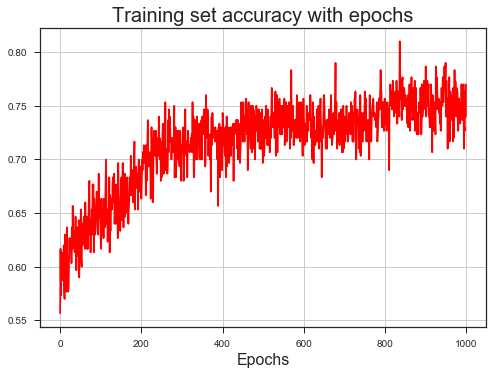

In [246]:
hist=run_NN(nn_model,X_train_scaled,y_train_scaled,verbosity=0,batch_size=16,
            num_epochs=1000,plot_loss=True)

In [247]:
score=test_NN(hist,X_test_scaled,y_test_scaled)
print("1-layer NN (using backpropagation) accuracy: ",score)

1-layer NN (using backpropagation) accuracy:  0.75


### Run 2-layer model with more neurons

In [248]:
nn_model2=make_2layer_NN(input_dim=input_dim,num_classes=num_classes,dropout_prob=0.2,learning_rate=0.0001,
                      neuron_layer_1=50,neuron_layer_2=25,optimizer='Adam')

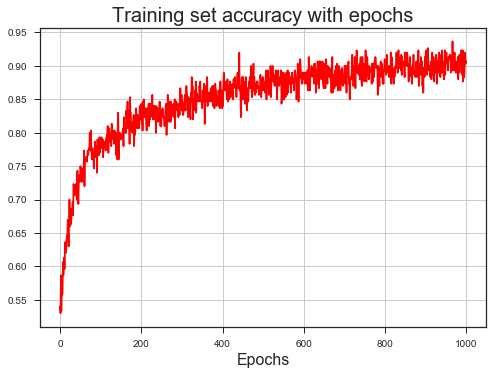

In [249]:
hist2=run_NN(nn_model2,X_train_scaled,y_train_scaled,verbosity=0,batch_size=16,
            num_epochs=1000,plot_loss=True)

In [250]:
score=test_NN(hist2,X_test_scaled,y_test_scaled)
print("2-layer NN with more neurons per layer (using backpropagation) accuracy: ",score)

2-layer NN with more neurons per layer (using backpropagation) accuracy:  0.805
